### Цель работы: 
Разработка единого пайплайна для решения задачи регрессии.

### Основные задачи:
- реализовать каонвейер для выполнения всех стадий обработки данных при решении задачи одномерной регрессии;
- получение теоретических представлений о задаче регресии;
- получение навыков использования пайплайна при решении задачи машинного обучения;
- получение навыков рефакторинга кода в задачах машинного обучения

## Описание колонок

Пусть у нас имеется некоторый набор данных sales.csv о продажах квартир:

- SalePrice (цена продажи, *зависимая переменная*).
- GrLivArea (наземная жилая зона).


### 1. Импорт библиотек

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns

### 2. Произведем чтение данных

In [38]:
import pandas as pd
df = pd.read_csv("sales.csv")
df = df.drop(columns = ['GarageArea','OverallQual','Street','SaleCondition'])
df.head()

,SalePrice,GrLivArea
0,208500,1710
1,181500,1262
2,223500,1786
3,140000,1717
4,250000,2198


Проверим пропуски в данных перед анализом зависимостей переменных

In [25]:
df.isna().sum()

SalePrice    0
GrLivArea    0
dtype: int64

Пропусков в данных не наблюдается


## Обработка пропущенных значений (если требуется)

In [ ]:
# from sklearn.preprocessing import Imputer
# imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# imputer = imputer.fit(df['SalePrice','GrLivArea'])
# df['SalePrice','GrLivArea'] = imputer.transform(df['SalePrice','GrLivArea'])
# print(X)

## Обработка категориальных данных (если требуется) 
### LabelEncoder

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# # Применение LabelEncoder к каждому категориальному столбцу
# for column in df.select_dtypes(include=['object']).columns:
#     df[column] = label_encoder.fit_transform(df[column])

# df.head()

## Обработка категориальных данных (если требуется) 
### OneHotEncoder

In [ ]:
# categorical_cols = df.select_dtypes(include=['object']).columns

# encoder = OneHotEncoder(sparse=False, drop='first')
# encoded_features = encoder.fit_transform(df[categorical_cols])

# # Создание DataFrame из закодированных признаков
# encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# # Объединение закодированных признаков с исходным DataFrame
# df = df.drop(columns=categorical_cols)  
# df = pd.concat([df, encoded_df], axis=1)  

# df.head()

В дальнейших шагах поставим себе цель - предсказать стоимость квартиры, т.е. SalePrice, по существующему признаку. 

1. Построим индивидуальные графики зависимости целевой функции и отдельной переменной:

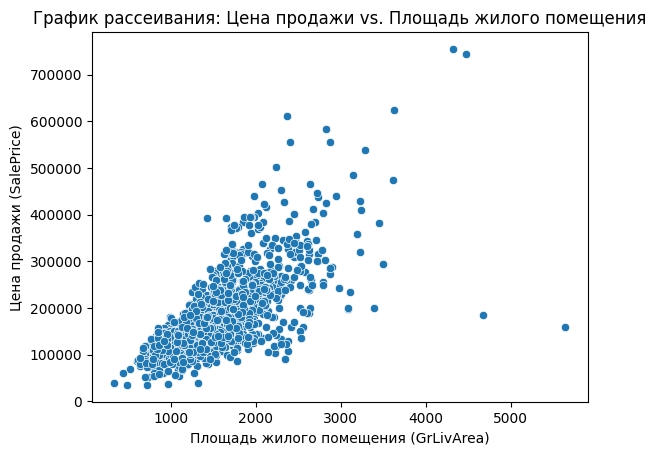

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ваш код здесь
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')
plt.title('График рассеивания: Цена продажи vs. Площадь жилого помещения')
plt.xlabel('Площадь жилого помещения (GrLivArea)')
plt.ylabel('Цена продажи (SalePrice)')
plt.show()


Обратим внимание на график рассеяния. По нему можно сделать вывод о том, что данные признаки имеют линейную зависимость друг от друга, а значит можно использовать Линейную регрессию для прогноза данных. При этом возникают выбросы стоимости в виду того, что целевая переменная SalePrice имеет очень большие значения.

Выведем матрицу корреляций для того, чтобы увериться в хорошей корреляции между переменными:

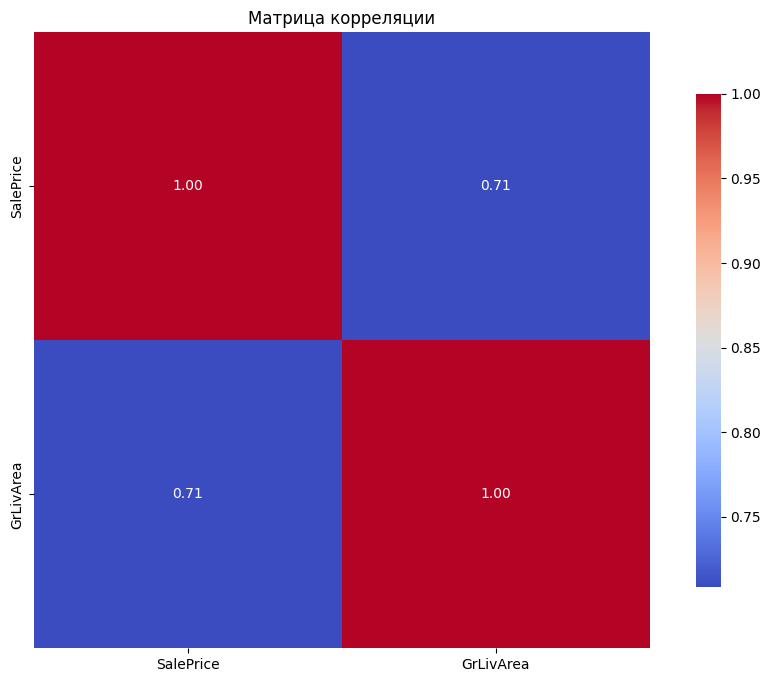

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляции')
plt.show()

Зависимость между данными превышает 0.7, что дает нам хорошую возможность для построения линейной регрессии

В данном случае здесь можно поработать с распределением признака SalesPrice, так как это сделет модель более точной за счет приведения распределения к нормальному

Проверим выбросы распределения цен:

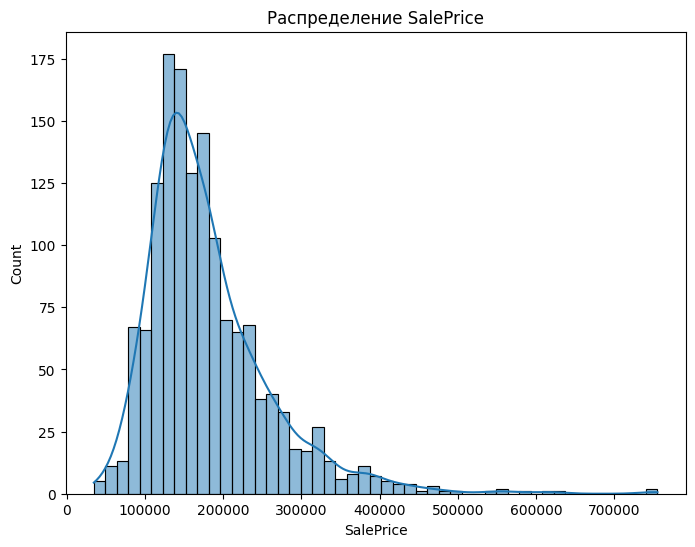

Минимальное значение SalePrice: 34900
Максимальное значение SalePrice: 755000


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Предположим, что df_encoded содержит наши данные с закодированными категориальными признаками
df_linear = df.copy()
y = df_linear['SalePrice']

# Проверяем распределение SalePrice
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True)
plt.title('Распределение SalePrice')
plt.show()

# Проверяем диапазон значений SalePrice
print(f'Минимальное значение SalePrice: {y.min()}')
print(f'Максимальное значение SalePrice: {y.max()}')


По данной гистограмме нельзя сказать об однозначных выбросах, цены действительно могут иметь такие значения, а потому будем рассматривать распределение данного признака.

Гистограмма распределения SalePrice показывает, что данные имеют правосторонне асимметричное распределение, с пиком в районе более низких цен и длинным "хвостом" в сторону более высоких цен. Также данная характеристика имеет довольно большой диапазон значений.

Попробуем логарифмировать целевую переменную SalePrice, чтобы привести распределение к более симметричному виду и улучшить качество модели:

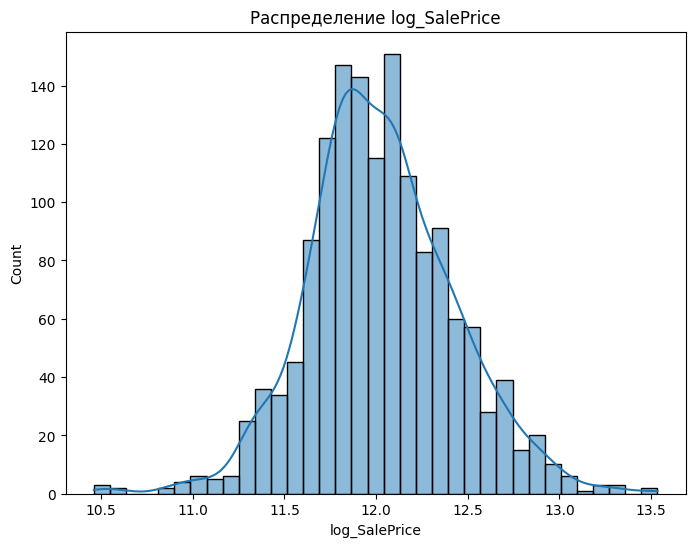

Минимальное значение log_SalePrice: 10.460242108190519
Максимальное значение log_SalePrice: 13.534473028231162


In [40]:
df_linear = df.copy()

# Логарифмируем SalePrice
df_linear['log_SalePrice'] = np.log(df_linear['SalePrice'])

# Проверяем распределение log_SalePrice
plt.figure(figsize=(8, 6))
sns.histplot(df_linear['log_SalePrice'], kde=True)
plt.title('Распределение log_SalePrice')
plt.show()

# Проверяем диапазон значений log_SalePrice
print(f'Минимальное значение log_SalePrice: {df_linear["log_SalePrice"].min()}')
print(f'Максимальное значение log_SalePrice: {df_linear["log_SalePrice"].max()}')


Распределение log_SalePrice выглядит более симметричным, чем исходное распределение SalePrice, а также диапазон значений стал значительно меньше.

### 4. Разделение на обучающую и тестовую выборки

In [42]:
# Ваш код здесь
x = df_linear.drop(['SalePrice', 'log_SalePrice'], axis=1)
y = df_linear['log_SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

### 5. Обучение модели линейной регрессии

Дополнительно можно взглянуть на коэффициенты и смещение обученной модели.

In [43]:
# Ваш код здесь
model = LinearRegression()
model.fit(x_train, y_train)
print('w_0:', model.intercept_)
print('остальные коэффициенты:', model.coef_)


w_0: 11.255261172730302
остальные коэффициенты: [0.00050592]


### 6. Получение предсказаний для обучающей и тестовой выборок

In [44]:
# Ваш код здесь
y_pred_train = model.predict(x_train)
y_predict_test = model.predict(x_test)

### 7. Проверка предсказаний

1. Проверим качество модели на обучающей и тестовой выборках с помощью MAE, MSE.
2. Построим диаграмму рассеяния целевой и предсказанной переменных. 

In [45]:
# Ваш код здесь
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 0.08300102125163085
Test MSE: 0.07740328385436979


In [46]:
from sklearn.metrics import mean_absolute_error

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_predict_test)
print("Train MAE: {}".format(train_mae))
print("Test MAE: {}".format(test_mae))

Train MAE: 0.21128889161199493
Test MAE: 0.2059052993029002


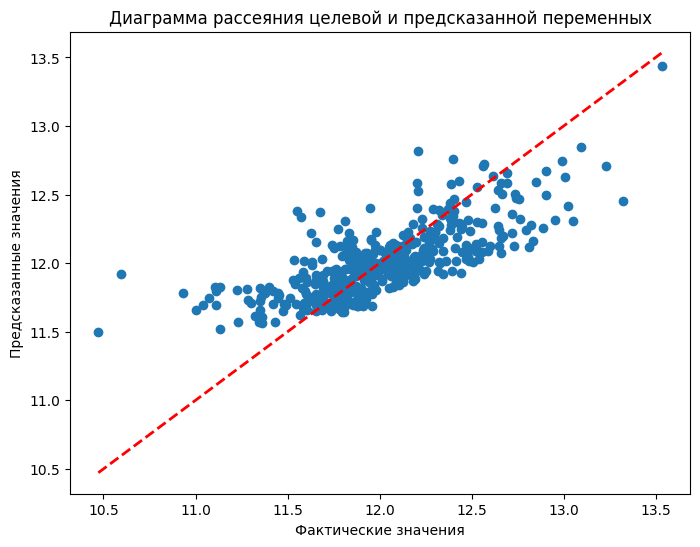

In [47]:
import matplotlib.pyplot as plt

# Предположим, что y_test - это целевая переменная, а y_pred - предсказанные значения
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predict_test)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Диаграмма рассеяния целевой и предсказанной переменных')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)
plt.show()


Таким образом, модель хорошо себя проявила, показав близкие к нулю MAE и MSE. Также модель не переобучена, потому как разница в ошибках при тестовой и тренировочной выборкой маленькая. По диаграмме рассеяния можно сделать вывод, что между целевой и предсказанной переменными существуюет сильная, положительная связь.